In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

In [2]:
import meds
import numpy as np
from metadetect import do_metadetect
from ngmix.medsreaders import MultiBandNGMixMEDS, NGMixMEDS
import yaml

In [28]:
config = yaml.safe_load("""

metacal:
  psf: fitgauss
  types: [noshear, 1p, 1m, 2p, 2m]
  use_noise_image: True

psf:
  lm_pars:
    maxfev: 2000
    ftol: 1.0e-05
    xtol: 1.0e-05
  model: gauss

  # we try many times because if this fails we get no psf info
  # for the entire patch
  ntry: 10

sx:
  # Minimum contrast parameter for deblending
  deblend_cont: 1.0e-05

  # in sky sigma
  detect_thresh: 0.8

  # minimum number of pixels above threshold
  minarea: 4

  filter_type: conv
  # 7x7 convolution mask of a gaussian PSF with FWHM = 3.0 pixels.
  filter_kernel:
    - [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963]
    - [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388]
    - [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328]
    - [0.068707, 0.296069, 0.710525, 0.951108, 0.710525, 0.296069, 0.068707]
    - [0.051328, 0.221178, 0.530797, 0.710525, 0.530797, 0.221178, 0.051328]
    - [0.021388, 0.092163, 0.221178, 0.296069, 0.221178, 0.092163, 0.021388]
    - [0.004963, 0.021388, 0.051328, 0.068707, 0.051328, 0.021388, 0.004963]

weight:
  fwhm: 1.2  # arcsec

# check for hitting the edge
bmask_flags: 1610612736  # 2**29 | 2**30

# fraction of slice where STAR or TRAIL was set.  We may cut objects detected
# there
star_flags: 96

# we don't interpolate over tapebumps
tapebump_flags: 16384

# things interpolated using the spline
spline_interp_flags: 3155

# replaced with noise
noise_interp_flags: 908

# pixels will have these flag set in the ormask if they were interpolated
# plus adding in tapebump and star
imperfect_flags: 20479

meds:
  box_padding: 2
  box_type: iso_radius
  max_box_size: 32
  min_box_size: 32
  rad_fac: 2
  rad_min: 4
""")

In [4]:
meds_list = [
    NGMixMEDS("/Users/beckermr/Downloads/DES0000-0207_r_des-pizza-slices-y6-v2_meds-pizza-slices.fits.fz"),
    NGMixMEDS("/Users/beckermr/Downloads/DES0000-0207_z_des-pizza-slices-y6-v2_meds-pizza-slices.fits.fz"),
]
mbmeds = MultiBandNGMixMEDS(meds_list)

In [ ]:
slice_ind = 7

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))

for ax, name in zip(axs.ravel(), ["image", "weight", "bmask", "ormask", "noise"]):
    ax.imshow(np.arcsinh(m.get_cutout(slice_ind, 0, type=name)))
    ax.grid(False)
    ax.set_aspect(1)
    ax.set_title(name)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)    
    
axs.ravel()[-1].axis("off")
fig.tight_layout()

In [29]:
import tqdm
from ngmix import ObsList, MultiBandObsList

for i in tqdm.trange(8, 9):
    rng = np.random.RandomState(seed=i)
    #     obs = m.get_obs(i, 0)
    #     obsl = ObsList()
    #     obsl.append(obs)
    #     mbobs = MultiBandObsList()
    #     mbobs.append(obsl)
    mbobs = mbmeds.get_mbobs(i)
    res = do_metadetect(config, mbobs, rng)

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


<IPython.core.display.Javascript object>


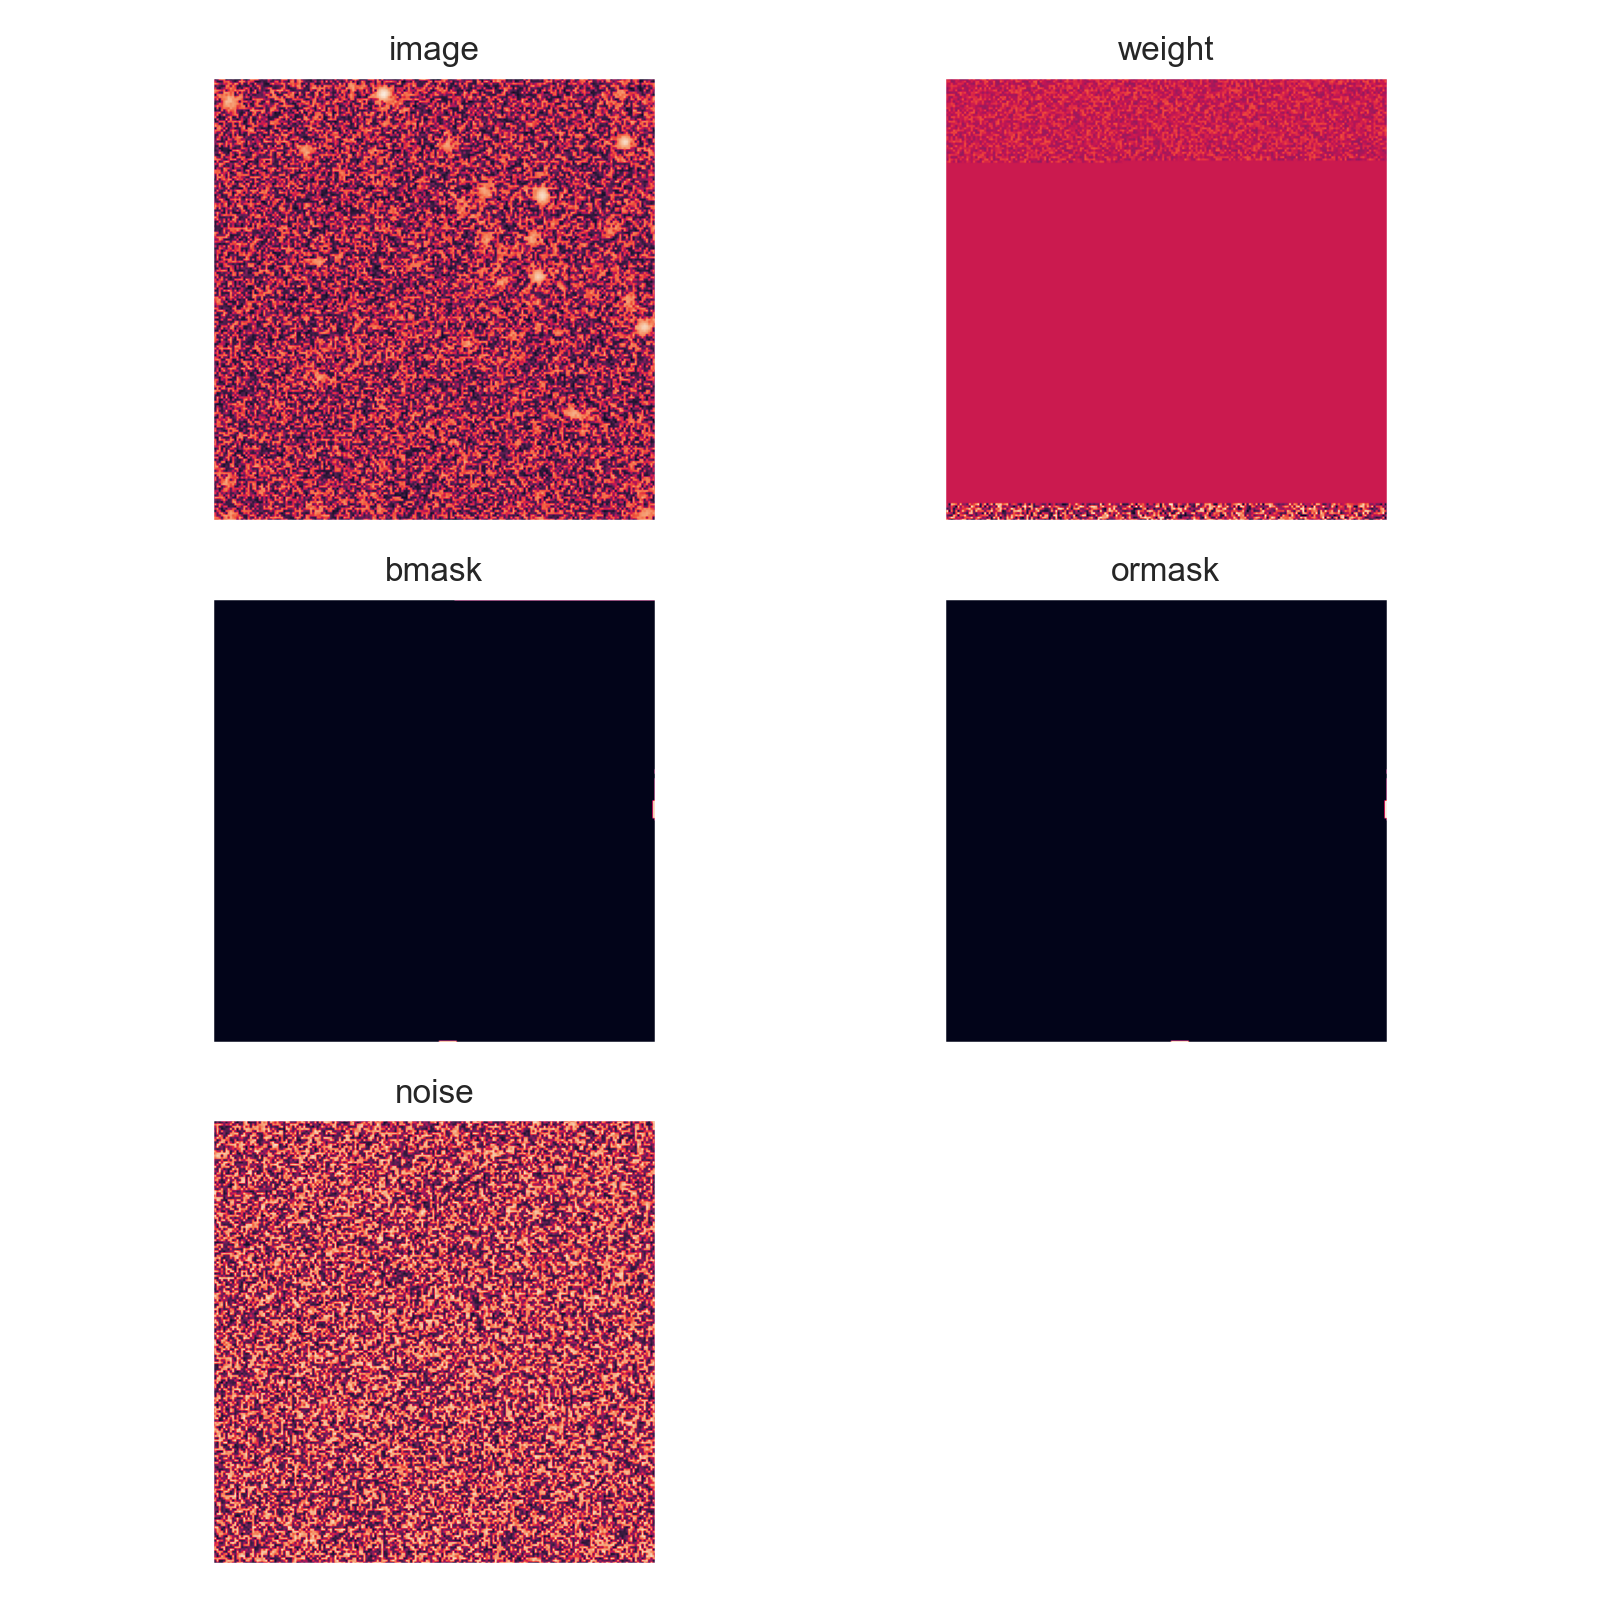

In [15]:
mbobs = mbmeds.get_mbobs(8)
obs = mbobs[1][0]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))

for ax, name in zip(axs.ravel(), ["image", "weight", "bmask", "ormask", "noise"]):
    img = getattr(obs, name)
    ax.imshow(np.arcsinh(img))
    ax.grid(False)
    ax.set_aspect(1)
    ax.set_title(name)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)    
    
axs.ravel()[-1].axis("off")
fig.tight_layout()

In [24]:
np.all(np.isfinite(obs.noise))

True

In [27]:
2**29 | 2**30

1610612736